In [1]:
# General imports
import numpy as np
import scipy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam

# Neurophox imports
from neurophox.numpy import *
from neurophox.tensorflow import *
from neurophox.ml import LinearMultiModelRunner
from neurophox.ml.linear import complex_mse
from neurophox.ml.nonlinearities import cnorm, cnormsq
from neurophox.initializers import *
from neurophox.components import *
from neurophox.helpers import *

import pyswarms as ps
import copy

In [2]:
plt.rcParams['text.usetex'] = True 
plt.rcParams['text.latex.preamble'] = r"\usepackage{siunitx} \usepackage{amsmath} \usepackage{sansmathfonts} \usepackage[T1]{fontenc} \renewcommand*\familydefault{\sfdefault}"

Given any unitary matrix $U$ belonging to $\text{SU(N)}$, we can decompose it using the function `clements_decomposition_working`.

$$ (\theta, \phi, \gamma) = f(U) $$

In [3]:
def clements_decomposition_working(u: np.ndarray, pbar_handle: Callable = None, smmzi: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Clements decomposition of unitary matrix :math:`U` to output the required phases for producing the matrix

    Args:
        u: unitary matrix :math:`U` to be decomposed into pairwise operators.
        pbar_handle: Useful for larger matrices

    Returns:
        The phases $(\theta, \phi, \gamma)$ layer that outputs the unitary :math:`U`

    """
    u_hat = u.T.copy()
    n = u.shape[0]
    # odd and even layer dimensions
    theta_checkerboard = np.zeros_like(u, dtype=NP_FLOAT)
    phi_checkerboard = np.zeros_like(u, dtype=NP_FLOAT)
    phi_checkerboard = np.hstack((np.zeros((n, 1)), phi_checkerboard))
    iterator = pbar_handle(range(n - 1)) if pbar_handle else range(n - 1)
    MZI = SMMZI if smmzi else BlochMZI
    for i in iterator:
        if i % 2:
            for j in range(i + 1):
                pairwise_index = n + j - i - 2
                target_row, target_col = n + j - i - 1, j
                theta = np.arctan(np.abs(u_hat[target_row - 1, target_col] / u_hat[target_row, target_col])) * 2
                phi = np.angle(u_hat[target_row, target_col] / u_hat[target_row - 1, target_col])
                mzi = MZI(theta, phi, hadamard=False, dtype=np.complex128)
                left_multiplier = mzi.givens_rotation(units=n, m=pairwise_index)
                u_hat = left_multiplier @ u_hat
                theta_checkerboard[pairwise_index, j] = theta
                phi_checkerboard[pairwise_index, j] = -phi + np.pi
                phi_checkerboard[pairwise_index + 1, j] = np.pi
        else:
            for j in range(i + 1):
                pairwise_index = i - j
                target_row, target_col = n - j - 1, i - j
                theta = np.arctan(np.abs(u_hat[target_row, target_col + 1] / u_hat[target_row, target_col])) * 2
                phi = np.angle(-u_hat[target_row, target_col] / u_hat[target_row, target_col + 1])
                mzi = BlochMZI(theta, phi, hadamard=False, dtype=np.complex128)
                right_multiplier = mzi.givens_rotation(units=n, m=pairwise_index)
                u_hat = u_hat @ right_multiplier.conj().T
                theta_checkerboard[pairwise_index, -j - 1] = theta
                phi_checkerboard[pairwise_index, -j - 1] = phi + np.pi

    diag_phases = np.angle(np.diag(u_hat))
    theta = checkerboard_to_param(np.fliplr(theta_checkerboard), n)
    phi_checkerboard = np.fliplr(phi_checkerboard)
    if n % 2:
        phi_checkerboard[:, :-1] += np.fliplr(np.diag(diag_phases))
    else:
        phi_checkerboard[:, 1:] += np.fliplr(np.diag(diag_phases))
        phi_checkerboard[-1, 2::2] += np.pi / 2  # neurophox layers assume pi / 2 phase shift in even layer "bounces"
        phi_checkerboard[0, 2::2] += np.pi / 2

    gamma = phi_checkerboard[:, 0]
    external_phases = phi_checkerboard[:, 1:]
    phi, gamma = grid_common_mode_flow(external_phases, gamma=gamma)
    phi = checkerboard_to_param(phi, n)

    # I don't understand this portion
    gamma_adj = np.zeros_like(gamma)
    gamma_adj[1::4] = 1
    gamma_adj[2::4] = 1
    gamma += np.pi * (1 - gamma_adj) if (n // 2) % 2 else np.pi * gamma_adj
    gamma = np.mod(gamma, 2 * np.pi)

    return theta, phi, gamma

def checkerboard_to_param(checkerboard: np.ndarray, units: int):
    param = np.zeros((units, units // 2))
    if units % 2:
        param[::2, :] = checkerboard.T[::2, :-1:2]
    else:
        param[::2, :] = checkerboard.T[::2, ::2]
    param[1::2, :] = checkerboard.T[1::2, 1::2]
    return param

def grid_common_mode_flow(external_phases: np.ndarray, gamma: np.ndarray, basis: str = "sm"):
    """In a grid mesh (e.g., triangular, rectangular meshes), arrange phases according to single-mode (:code:`sm`),
       differential mode (:code:`diff`), or max-:math:`\\pi` (:code:`maxpi`, all external phase shifts are at most
       :math:`\\pi`). This is done using a procedure called "common mode flow" where common modes are shifted
       throughout the mesh until phases are correctly set.

    Args:
        external_phases: external phases in the grid mesh
        gamma: input phase shifts
        basis: single-mode (:code:`sm`), differential mode (:code:`diff`), or max-:math:`\\pi` (:code:`maxpi`)

    Returns:
        new external phases shifts and new gamma resulting

    """
    units, num_layers = external_phases.shape
    phase_shifts = np.hstack((gamma[:, np.newaxis], external_phases)).T
    new_phase_shifts = np.zeros_like(external_phases.T)

    for i in range(num_layers):
        current_layer = num_layers - i
        start_idx = (current_layer - 1) % 2
        end_idx = units - (current_layer + units - 1) % 2
        # calculate phase information
        upper_phase = phase_shifts[current_layer][start_idx:end_idx][::2]
        lower_phase = phase_shifts[current_layer][start_idx:end_idx][1::2]
        upper_phase = np.mod(upper_phase, 2 * np.pi)
        lower_phase = np.mod(lower_phase, 2 * np.pi)
        if basis == "sm":
            new_phase_shifts[-i - 1][start_idx:end_idx][::2] = upper_phase - lower_phase
        # assign differential phase to the single mode layer and keep common mode layer
        else:
            phase_diff = upper_phase - lower_phase
            phase_diff[phase_diff > np.pi] -= 2 * np.pi
            phase_diff[phase_diff < -np.pi] += 2 * np.pi
            if basis == "diff":
                new_phase_shifts[-i - 1][start_idx:end_idx][::2] = phase_diff / 2
                new_phase_shifts[-i - 1][start_idx:end_idx][1::2] = -phase_diff / 2
            elif basis == "pimax":
                new_phase_shifts[-i - 1][start_idx:end_idx][::2] = phase_diff * (phase_diff >= 0)
                new_phase_shifts[-i - 1][start_idx:end_idx][1::2] = -phase_diff * (phase_diff < 0)
        # update the previous layer with the common mode calculated for the current layer\
        phase_shifts[current_layer] -= new_phase_shifts[-i - 1]
        phase_shifts[current_layer - 1] += np.mod(phase_shifts[current_layer], 2 * np.pi)
        phase_shifts[current_layer] = 0
    new_gamma = np.mod(phase_shifts[0], 2 * np.pi)
    return np.mod(new_phase_shifts.T, 2 * np.pi), new_gamma

In [4]:
def NormalPhaseInitializer(layer: RM, sigma : float):
    """Initialises a mesh layer with phases from a normal distribution 

    Args:
        layer (RM): Neurophox rectangular mesh layer
        sigma (float): Standard deviation of the phase distribution
    """
    theta_b = (2 * np.pi * abs(np.random.normal(0, sigma, layer.theta.shape))) % np.pi
    theta_b[1::2, -1] = 0

    phi_b = (2 * np.pi * abs(np.random.normal(0, sigma, layer.phi.shape))) % (2 * np.pi)
    phi_b[1::2, -1] = 0

    gamma_b = (2 * np.pi * abs(np.random.normal(0, sigma, layer.gamma.shape))) % (2 * np.pi)

    t_ = tf.convert_to_tensor(theta_b, dtype=tf.float32)
    p_ = tf.convert_to_tensor(phi_b, dtype=tf.float32)
    g_ = tf.convert_to_tensor(gamma_b.reshape(1, -1), dtype=tf.float32)
    layer.theta.assign(t_)
    layer.phi.assign(p_)
    layer.gamma.assign(g_)
    return theta_b, phi_b, gamma_b

In [5]:
def frobenius_loss(A_true: tf.Tensor, A_pred: tf.Tensor):
    loss = tf.math.real(tf.norm(tf.subtract(A_true, A_pred)))
    return loss

## Unitary Chip simulation:

Let the passive transfer matrix of our chip be $A$ (detected from experiment). We optimise the phases of an ideal MZI mesh with transfer matrix $\hat A(\theta, \phi, \gamma)$ to make it as close as possible to $A$, thereby computing the phase errors.

- Loss Criterion: $ \|\hat A - A \|_F^2,$ (Frobenius Norm)
- Optimizer: Adam

In [6]:
def train_layer(layer, x_train, y_train, loss_fn, optimizer, iterations=10000):
    losses = []
    best_loss = np.inf
    best_layer = None
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            loss = loss_fn(layer(x_train), y_train)
        grads = tape.gradient(loss, layer.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, layer.trainable_variables))
        losses.append(np.mean(loss))
        
        if losses[-1] < best_loss:
            best_loss = losses[-1]
            best_layer = copy.deepcopy(layer)
        
        if (i+1) % 1000 == 0:
            print(f"{i+1} iterations completed. Best Loss = {best_loss}")
    
    return best_layer, best_loss, losses

### Step 1: Initialising Phase Errors

In [7]:
U = RM(6)
phase_errors = NormalPhaseInitializer(U, 0.1)

: 

### Step 2: Initialising Ideal Mesh

In [8]:
target_matrix = U.matrix
# Instantiate an optimizer
optimizer = Adam(learning_rate=0.001)
# Instantiate a loss function
loss_fn = complex_mse
# Instantiate the ideal mesh
layer = RM(6)
# Preparing the training data
x_train, y_train = tf.eye(layer.units, dtype=TF_COMPLEX),\
                               tf.convert_to_tensor(target_matrix, dtype=TF_COMPLEX)

### Step 2: Training

In [9]:
best_layer, best_loss, losses = train_layer(layer, x_train, y_train, loss_fn, optimizer, 50000)

1000 iterations completed.
2000 iterations completed.
3000 iterations completed.
4000 iterations completed.
5000 iterations completed.
6000 iterations completed.
7000 iterations completed.
8000 iterations completed.
9000 iterations completed.
10000 iterations completed.
11000 iterations completed.
12000 iterations completed.
13000 iterations completed.
14000 iterations completed.
15000 iterations completed.
16000 iterations completed.
17000 iterations completed.
18000 iterations completed.
19000 iterations completed.
20000 iterations completed.
21000 iterations completed.
22000 iterations completed.
23000 iterations completed.
24000 iterations completed.
25000 iterations completed.
26000 iterations completed.
27000 iterations completed.
28000 iterations completed.
29000 iterations completed.
30000 iterations completed.
31000 iterations completed.
32000 iterations completed.
33000 iterations completed.
34000 iterations completed.
35000 iterations completed.
36000 iterations completed.
3

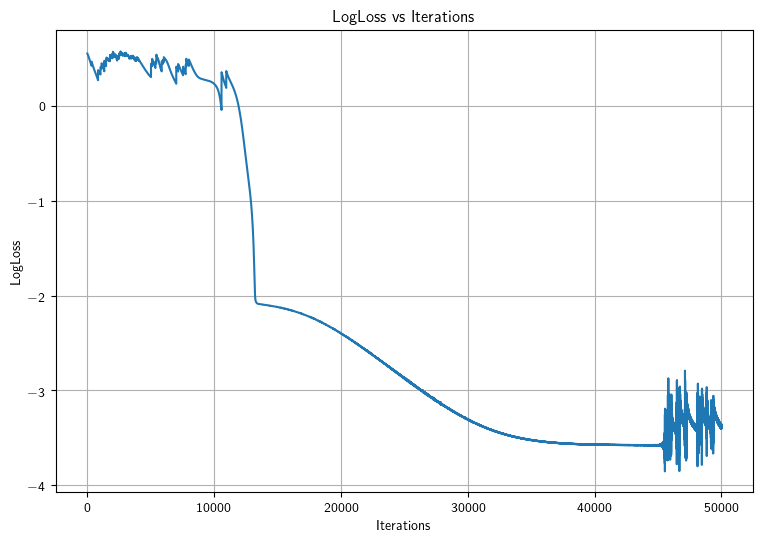

In [10]:
plt.figure(figsize=(9, 6))
plt.plot(np.arange(50000), np.log10(losses))
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.title('LogLoss vs Iterations')
plt.grid()

### Results

In [11]:
print('Best Loss =', best_loss)

Best Loss = 0.00013935135


In [12]:
print('Target Matrix A: \n', target_matrix, '\n')
print('Estimated Matrix: \n', best_layer.matrix)

Target Matrix A: 
 [[ 2.7977875e-02+0.05560299j -2.9605171e-02-0.08301689j
   1.6918277e-02+0.15323034j -1.1548535e-01-0.17661786j
   9.8285303e-02+0.0881139j   9.0478593e-01+0.28982612j]
 [-7.5793080e-03+0.02368651j -2.8051892e-03+0.04859413j
   1.5523279e-02-0.2996428j   2.0770712e-02+0.18378331j
   5.0866228e-01+0.78268063j -3.3596147e-02-0.01796177j]
 [-4.7897160e-02+0.07810006j -3.6834940e-02-0.1317861j
   1.4045487e-02+0.08516818j  6.3835150e-01+0.7030629j
  -1.4394587e-01-0.04189953j  2.0233829e-01+0.01497144j]
 [ 1.7962918e-02-0.12197175j -5.4956232e-03+0.07083093j
  -3.7241105e-02+0.92987895j -1.2128641e-02+0.02143236j
   1.6218711e-01+0.23761018j -1.5866801e-01-0.0717357j ]
 [-3.0882157e-02+0.00801164j -3.2334277e-01+0.92801726j
   5.3415773e-04-0.02860693j  2.2758115e-02+0.10072228j
  -3.1955928e-02-0.06804217j  8.1371352e-02+0.09727093j]
 [-8.0306679e-01+0.57094586j -1.3553615e-02-0.01185162j
  -8.0442049e-02+0.07352026j -4.1392505e-02-0.08055285j
   1.1254592e-02+0.0152548

In [13]:
print('Actual theta errors: \n', phase_errors[0], '\n')
print('Estimated theta errors: \n', abs(best_layer.theta.numpy()), '\n')
print('Max theta error: \n', np.max(abs(phase_errors[0] - abs(best_layer.theta.numpy()))))

Actual theta errors: 
 [[0.08015368 0.15619087 0.06473562]
 [0.32900161 0.20032798 0.        ]
 [0.59537249 0.15758512 0.28989406]
 [0.01244806 0.19832871 0.        ]
 [0.22055053 0.11312771 0.47761992]
 [0.06130728 0.37242396 0.        ]] 

Estimated theta errors: 
 [[0.08030418 0.15621491 0.06478324]
 [0.32894018 0.20030318 0.        ]
 [0.5953447  0.15754735 0.2898586 ]
 [0.0124265  0.19827697 0.        ]
 [0.22052099 0.11310104 0.47763482]
 [0.06127482 0.37245032 0.        ]] 

Max theta error: 
 0.00015050667745071522


In [14]:
print('Actual phi errors: \n', phase_errors[1], '\n')
print('Estimated phi errors: \n', best_layer.phi.numpy(), '\n')
print('Max phi error: \n', np.max(abs(phase_errors[1] - best_layer.phi.numpy()) % (2*np.pi)))

Actual phi errors: 
 [[0.50305547 0.046811   0.22886573]
 [0.5469096  1.04154113 0.        ]
 [0.62988218 0.55484014 0.22967637]
 [0.22242964 0.27149926 0.        ]
 [0.11762738 0.47408419 0.22673621]
 [0.20791267 0.47770812 0.        ]] 

Estimated phi errors: 
 [[0.5030754  0.04681392 0.22886865]
 [0.54691327 1.0415473  0.        ]
 [0.62988603 0.55385435 0.22969323]
 [0.22342    0.27151534 0.        ]
 [0.11762919 0.47410098 0.22674017]
 [0.2079308  0.47771278 0.        ]] 

Max phi error: 
 0.0009903547289227543


In [15]:
print('Actual gamma errors: \n', phase_errors[2], '\n')
print('Estimated gamma errors: \n', best_layer.gamma.numpy(), '\n')
print('Max gamma error: \n', np.max(abs(phase_errors[2] - best_layer.gamma.numpy()) % (2*np.pi)))

Actual gamma errors: 
 [[0.30999823 0.49097225 0.12446089 0.386666   0.7224583  0.35824679]] 

Estimated gamma errors: 
 [[0.31000894 0.4909673  0.12446598 0.38666832 0.7224752  0.35824996]] 

Max gamma error: 
 1.68688954288454e-05


Complex MSE

In [13]:
U = RM(6)
phase_errors = NormalPhaseInitializer(U, 0.1)

In [14]:
target_matrix = U.matrix
# Instantiate an optimizer
optimizer = Adam(learning_rate=0.0025)
# Instantiate a loss function
loss_fn = complex_mse
# Instantiate the ideal mesh
layer = RM(6)
# Preparing the training data
x_train, y_train = tf.eye(layer.units, dtype=TF_COMPLEX),\
                               tf.convert_to_tensor(target_matrix, dtype=TF_COMPLEX)

In [23]:
best_layer2, best_loss2, losses2 = train_layer(layer, x_train, y_train, loss_fn, optimizer, 25000)

1000 iterations completed. Best Loss = 1.1629876439656073e-07
2000 iterations completed. Best Loss = 1.060508409977956e-07
3000 iterations completed. Best Loss = 9.514846510683128e-08
4000 iterations completed. Best Loss = 8.56445936392447e-08
5000 iterations completed. Best Loss = 7.699769355440367e-08
6000 iterations completed. Best Loss = 6.914613237540834e-08
7000 iterations completed. Best Loss = 6.185584311424464e-08
8000 iterations completed. Best Loss = 5.533088298648181e-08
9000 iterations completed. Best Loss = 4.9504354393548056e-08
10000 iterations completed. Best Loss = 4.397413633228098e-08
11000 iterations completed. Best Loss = 3.913606860805885e-08
12000 iterations completed. Best Loss = 3.512923640869303e-08
13000 iterations completed. Best Loss = 3.088426581143722e-08
14000 iterations completed. Best Loss = 2.743781557512648e-08
15000 iterations completed. Best Loss = 2.4474479332070587e-08
16000 iterations completed. Best Loss = 2.1530325966523378e-08
17000 iteratio

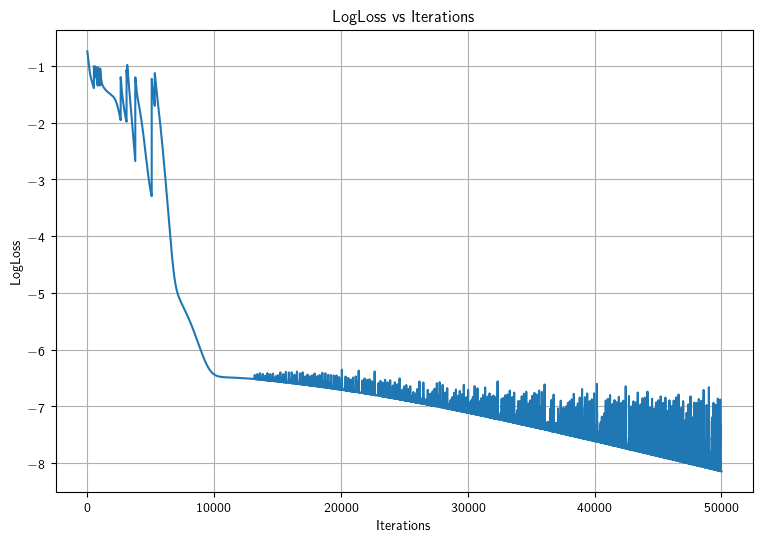

In [24]:
plt.figure(figsize=(9, 6))
plt.plot(np.arange(50000), np.log10(losses+losses2))
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.title('LogLoss vs Iterations')
plt.grid()

In [25]:
print('Best Loss =', best_loss2)

Best Loss = 7.13953e-09


In [26]:
print('Target Matrix A: \n', target_matrix, '\n')
print('Estimated Matrix: \n', best_layer2.matrix)

Target Matrix A: 
 [[-0.01820051+0.15845251j  0.25619918-0.11662222j -0.11729693+0.03154155j
   0.09437371-0.19390352j  0.23274818+0.26752385j  0.6427537 +0.5433151j ]
 [-0.03719648-0.00191747j -0.01841702+0.1881166j  -0.1204396 -0.19699688j
   0.01646028+0.07105994j  0.90758   +0.017685j   -0.28319514-0.00616286j]
 [ 0.13938913+0.18796484j -0.0541826 +0.01605893j -0.33328804+0.33819297j
   0.08126377+0.82945436j -0.00417947+0.10233202j  0.10707994-0.00610614j]
 [ 0.326567  +0.03466558j -0.04403376-0.05654931j -0.7601409 -0.23170918j
   0.3018236 -0.30707908j -0.13971297+0.09478655j -0.09073178-0.182704j  ]
 [-0.55363137+0.15907845j -0.48638788-0.58687246j -0.10587507+0.08607581j
   0.20696482-0.04247659j  0.05907332-0.02612089j -0.11414493+0.0820716j ]
 [-0.0953916 +0.6853127j   0.53059274-0.11909129j  0.047539  +0.23258513j
  -0.02839934-0.15078545j  0.01062708+0.08346618j -0.28268024-0.2421767j ]] 

Estimated Matrix: 
 [[-0.01820095+0.15845335j  0.25619778-0.11664382j -0.11729447+0.

In [30]:
print('Actual theta errors: \n', phase_errors[0], '\n')
print('Estimated theta errors: \n', abs(best_layer2.theta.numpy()), '\n')
print('Max theta error: \n', np.max(abs(phase_errors[0] - abs(best_layer2.theta.numpy()))))
print('Mean theta error: \n', np.mean(abs(phase_errors[0] - abs(best_layer2.theta.numpy()))))

Actual theta errors: 
 [[6.49317815e-01 1.02262210e+00 1.38850867e+00]
 [2.86793617e-01 5.98110498e-01 0.00000000e+00]
 [4.13759939e-01 3.46715898e-01 9.37242072e-03]
 [6.51236908e-02 6.94386671e-01 0.00000000e+00]
 [5.88812705e-01 2.20129345e-01 5.01951035e-01]
 [1.02087846e-01 7.07789161e-04 0.00000000e+00]] 

Estimated theta errors: 
 [[6.4928228e-01 1.0226299e+00 1.3885497e+00]
 [2.8676367e-01 5.9814239e-01 0.0000000e+00]
 [4.1374585e-01 3.4671101e-01 9.2991181e-03]
 [6.5116100e-02 6.9441098e-01 0.0000000e+00]
 [5.8879679e-01 2.2013080e-01 5.0219136e-01]
 [1.0211687e-01 8.1395323e-04 0.0000000e+00]] 

Max theta error: 
 0.00024032967447906728
Mean theta error: 
 3.6844755467398845e-05


In [34]:
print('Actual phi errors: \n', phase_errors[1], '\n')
print('Estimated phi errors: \n', best_layer2.phi.numpy(), '\n')
print('Max phi error: \n', np.max(abs(phase_errors[1] - best_layer2.phi.numpy()) % (2*np.pi)))
print('Mean phi error: \n', np.mean(abs(phase_errors[1] - best_layer2.phi.numpy()) % (2*np.pi)))
abs(phase_errors[1] - best_layer2.phi.numpy())

SyntaxError: incomplete input (3034771388.py, line 5)

In [ ]:
print('Actual gamma errors: \n', phase_errors[2], '\n')
print('Estimated gamma errors: \n', best_layer.gamma.numpy(), '\n')
print('Max gamma error: \n', np.max(abs(phase_errors[2] - best_layer.gamma.numpy()) % (2*np.pi)))

Actual gamma errors: 
 [[0.30999823 0.49097225 0.12446089 0.386666   0.7224583  0.35824679]] 

Estimated gamma errors: 
 [[0.31000894 0.4909673  0.12446598 0.38666832 0.7224752  0.35824996]] 

Max gamma error: 
 1.68688954288454e-05


## Matrix Chip simulation:

Without bounding of parameters:

In [98]:
A = SVD(6, mesh_dict = {"name" : "rm"})

phasesU = NormalPhaseInitializer(A.u, 0.1)       # Phases Errors in U

phasesVt = NormalPhaseInitializer(A.v, 0.1)       # Phases Errors in Vt

# layerS = CustomDiagonal(6)      # S (Sigma) block of our chip
# phasesDiag = (np.pi * abs(np.random.normal(0, 0.1, (6, 2)))) % np.pi       # Phases Errors in S
# # Assign the phase errors
# pD_ = tf.convert_to_tensor(phasesDiag, dtype=tf.float32)
# layerS.phases.assign(pD_)

# A.diag = layerS

In [99]:
def constraint_fn(upper_bound):
    return lambda x: x - (upper_bound * tf.floor(x / upper_bound))

In [100]:
target_matrix = A.matrix
# Instantiate an optimizer
optimizer = Adam(learning_rate=0.0025)
# Instantiate a loss function
loss_fn = frobenius_loss
# Instantiate the ideal mesh
layer = SVD(6, mesh_dict={"name" : "rm"})

# g = np.zeros((1, 6))
# g_ = tf.convert_to_tensor(g, dtype=tf.float32)
# layer.u.gamma.assign(g_)
# Preparing the training data
x_train, y_train = tf.eye(layer.units, dtype=TF_COMPLEX),\
                               tf.convert_to_tensor(target_matrix, dtype=TF_COMPLEX)

In [101]:
def train_SVD_layer(layer, x_train, y_train, loss_fn, optimizer, iterations=10000):
    losses = []
    best_loss = np.inf
    best_layer = None
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            loss = loss_fn(layer(x_train), y_train)
        grads = tape.gradient(loss, layer.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, layer.trainable_variables))
        losses.append(np.mean(loss))
        
        if losses[-1] < best_loss:
            best_loss = losses[-1]
            best_layer = copy.deepcopy(layer)
        
        if (i+1) % 1000 == 0:
            print(f"{i+1} iterations completed. Best Loss = {best_loss}")
    
    return best_layer, best_loss, losses

In [102]:
best_layer, best_loss, losses = train_layer(layer, x_train, y_train, loss_fn, optimizer, 25000)

1000 iterations completed. Best Loss = 1.9046701192855835
2000 iterations completed. Best Loss = 1.658984661102295
3000 iterations completed. Best Loss = 0.7896625995635986
4000 iterations completed. Best Loss = 0.7429944276809692
5000 iterations completed. Best Loss = 0.22697268426418304
6000 iterations completed. Best Loss = 0.22697268426418304
7000 iterations completed. Best Loss = 0.22697268426418304
8000 iterations completed. Best Loss = 0.19196589291095734
9000 iterations completed. Best Loss = 0.15569399297237396
10000 iterations completed. Best Loss = 0.12842339277267456
11000 iterations completed. Best Loss = 0.09558508545160294
12000 iterations completed. Best Loss = 0.08566964417695999
13000 iterations completed. Best Loss = 0.08566964417695999
14000 iterations completed. Best Loss = 0.08566964417695999
15000 iterations completed. Best Loss = 0.08566964417695999
16000 iterations completed. Best Loss = 0.08566964417695999
17000 iterations completed. Best Loss = 0.081264771521

In [113]:
best_layer2, best_loss2, losses2 = train_layer(layer, x_train, y_train, loss_fn, optimizer, 35000)

1000 iterations completed. Best Loss = 0.0525040440261364
2000 iterations completed. Best Loss = 0.018170475959777832
3000 iterations completed. Best Loss = 0.018170475959777832
4000 iterations completed. Best Loss = 0.008892877958714962
5000 iterations completed. Best Loss = 0.007377805188298225
6000 iterations completed. Best Loss = 0.007377805188298225
7000 iterations completed. Best Loss = 0.007377805188298225
8000 iterations completed. Best Loss = 0.007377805188298225
9000 iterations completed. Best Loss = 0.007377805188298225
10000 iterations completed. Best Loss = 0.007377805188298225
11000 iterations completed. Best Loss = 0.007377805188298225
12000 iterations completed. Best Loss = 0.007377805188298225
13000 iterations completed. Best Loss = 0.007377805188298225
14000 iterations completed. Best Loss = 0.007377805188298225
15000 iterations completed. Best Loss = 0.007377805188298225
16000 iterations completed. Best Loss = 0.007377805188298225
17000 iterations completed. Best Lo

In [130]:
best_layer2c, best_loss2c, losses2c = train_layer(layer, x_train, y_train, loss_fn, optimizer, 40000)

1000 iterations completed. Best Loss = 0.0016024368815124035
2000 iterations completed. Best Loss = 0.0014636125415563583
3000 iterations completed. Best Loss = 0.0013345713960006833
4000 iterations completed. Best Loss = 0.0012101175962015986
5000 iterations completed. Best Loss = 0.001106337527744472
6000 iterations completed. Best Loss = 0.0010228927712887526
7000 iterations completed. Best Loss = 0.0009405260207131505
8000 iterations completed. Best Loss = 0.0008647186914458871
9000 iterations completed. Best Loss = 0.0008089994080364704
10000 iterations completed. Best Loss = 0.0007568678702227771
11000 iterations completed. Best Loss = 0.0007096664048731327
12000 iterations completed. Best Loss = 0.0006662047235295177
13000 iterations completed. Best Loss = 0.0006306869327090681
14000 iterations completed. Best Loss = 0.0006021213484928012
15000 iterations completed. Best Loss = 0.0005753866862505674
16000 iterations completed. Best Loss = 0.0005541101563721895
17000 iterations c

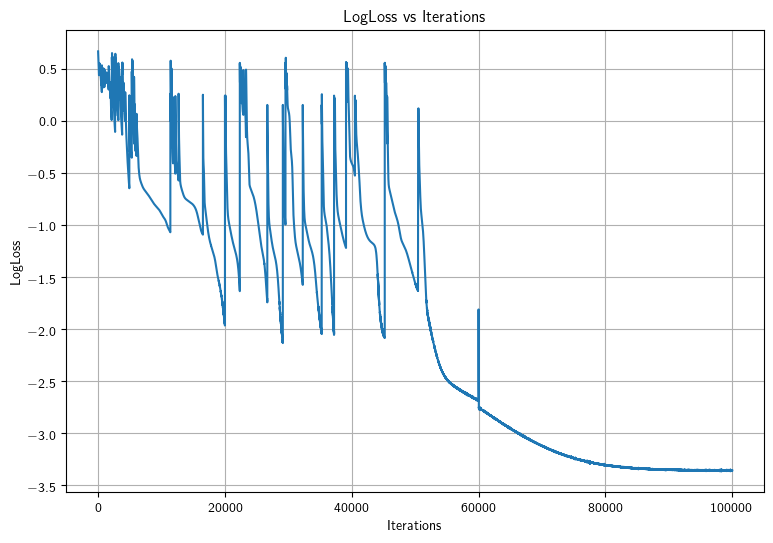

In [132]:
plt.figure(figsize=(9, 6))
plt.plot(np.arange(100000), np.log10(losses+losses2+losses2c))
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.title('LogLoss vs Iterations')
plt.grid()

### Results

In [133]:
print('Best Loss =', best_loss2c)

Best Loss = 0.00043144877


In [134]:
print('Target Matrix A: \n', target_matrix, '\n')
print('Estimated Matrix: \n', best_layer2c.matrix)

Target Matrix A: 
 [[-1.2076019e-02-0.16957785j -4.0069375e-02+0.04512367j
  -1.2436297e-01-0.05335169j  1.8199895e-02+0.06876295j
   1.2298697e-01+0.16376708j -2.3728589e-02+0.02092925j]
 [-9.9211675e-04-0.02420189j -4.3136334e-01-0.13610402j
   1.1595549e-01-0.06936625j  4.4327270e-02-0.1762671j
  -4.4417694e-02-0.24009101j  1.4369303e-01-0.2864853j ]
 [ 1.8186893e-01+0.21282199j -9.2359111e-02+0.02156837j
  -4.3372747e-01+0.21956632j  1.1644358e-01-0.03259489j
  -5.4678388e-02+0.18535025j  8.8316180e-02-0.03053141j]
 [-3.8436309e-02-0.10939515j -9.8685138e-02+0.04797215j
   5.8628570e-02+0.04939371j  3.4522256e-01+0.5002045j
  -2.3117352e-01-0.07141333j -2.3343398e-01-0.3618879j ]
 [ 6.0745016e-02-0.02986369j  2.6144204e-01-0.18084191j
  -7.7314906e-02+0.23790427j  8.7130062e-02-0.19415614j
  -2.1562985e-01-0.888875j   -5.2644361e-02-0.00288028j]
 [ 5.7494406e-02+0.20318013j  7.5984262e-02+0.02139859j
  -4.6550885e-01-0.22404018j -9.6956410e-02-0.04157248j
  -1.7855230e-01-0.1426944

U block

In [135]:
print('Actual theta errors: \n', A.u.theta.numpy(), '\n')
print('Estimated theta errors: \n', abs(best_layer2c.u.theta.numpy()), '\n')
print('Max theta error: \n', np.max(abs(A.u.theta.numpy() - best_layer2c.u.theta.numpy())))

Actual theta errors: 
 [[0.04633745 0.04560137 0.09698534]
 [0.17843728 0.05690179 0.        ]
 [0.31693366 0.06364431 0.2558745 ]
 [0.34796074 0.47843537 0.        ]
 [0.27468938 0.5305444  0.01975558]
 [0.21960422 0.04619819 0.        ]] 

Estimated theta errors: 
 [[2.9441087  3.0686605  2.8298252 ]
 [0.24911243 0.68696785 0.        ]
 [0.89115214 0.8359218  1.1144232 ]
 [2.5121248  2.6986995  0.        ]
 [0.93036777 1.4848489  1.444464  ]
 [0.14928254 2.2938812  0.        ]] 

Max theta error: 
 3.0230591


In [122]:
print('Actual phi errors: \n', A.u.phi.numpy(), '\n')
print('Estimated phi errors: \n', best_layer2.u.phi.numpy(), '\n')
print('Max phi error: \n', np.max(abs(A.u.phi.numpy() - best_layer2.u.phi.numpy()) % (2*np.pi)))

Actual phi errors: 
 [[0.3876521  0.02389402 1.3222289 ]
 [0.3699358  0.24657306 0.        ]
 [0.07290575 0.5080419  0.4667073 ]
 [0.3044982  1.0528481  0.        ]
 [0.28336847 0.1579131  0.9293724 ]
 [0.29256448 0.31220868 0.        ]] 

Estimated phi errors: 
 [[3.7369094 2.8352082 5.237811 ]
 [1.4437385 0.9139667 0.       ]
 [2.034452  0.6504509 6.0958557]
 [5.204548  3.7189248 0.       ]
 [4.9000835 3.4602404 4.6057296]
 [5.0391617 2.123642  0.       ]] 

Max phi error: 
 5.6291485


In [123]:
print('Actual gamma errors: \n', A.u.gamma.numpy(), '\n')
print('Estimated gamma errors: \n', best_layer2.u.gamma.numpy(), '\n')
print('Max gamma error: \n', np.max(abs(A.u.gamma.numpy() - best_layer2.u.gamma.numpy()) % (2*np.pi)))

Actual gamma errors: 
 [[0.47516033 0.873801   0.13602072 0.05294719 0.56878394 0.5546186 ]] 

Estimated gamma errors: 
 [[4.2327185 4.202729  4.045976  2.858011  4.856375  2.5224798]] 

Max gamma error: 
 4.2875915


Vt block

In [124]:
print('Actual theta errors: \n', A.v.theta.numpy(), '\n')
print('Estimated theta errors: \n', abs(best_layer2.v.theta.numpy()), '\n')
print('Max theta error: \n', np.max(abs(A.v.theta.numpy() - best_layer2.v.theta.numpy())))

Actual theta errors: 
 [[0.08874158 0.52359337 0.28543538]
 [0.46697548 0.33933786 0.        ]
 [0.4698871  0.0914452  0.02060224]
 [0.11284027 0.19175936 0.        ]
 [0.99799776 0.70637757 0.01358532]
 [0.08768497 0.3287697  0.        ]] 

Estimated theta errors: 
 [[2.108203  1.9844754 2.3462467]
 [2.1670964 1.9437575 0.       ]
 [1.0691879 0.845577  2.2522707]
 [2.2363102 1.3729994 0.       ]
 [0.9104289 2.1159542 2.4890528]
 [2.4924614 2.0189407 0.       ]] 

Max theta error: 
 2.4754674


In [125]:
print('Actual phi errors: \n', A.v.phi.numpy(), '\n')
print('Estimated phi errors: \n', best_layer2.v.phi.numpy(), '\n')
print('Max phi error: \n', np.max(abs(A.v.phi.numpy() - best_layer2.v.phi.numpy()) % (2*np.pi)))

Actual phi errors: 
 [[0.7016189  0.1833777  0.6705305 ]
 [0.10069744 1.2466946  0.        ]
 [0.11411777 0.5376667  0.80274487]
 [0.2503532  0.05836657 0.        ]
 [1.2322732  0.3273497  0.02574901]
 [0.46936956 0.2935382  0.        ]] 

Estimated phi errors: 
 [[0.35998753 3.3103018  5.643938  ]
 [5.0999675  0.33554038 0.        ]
 [0.74291474 5.391533   5.317107  ]
 [5.2052345  2.6889038  0.        ]
 [3.3378856  1.1173398  3.1028697 ]
 [1.0220901  5.404517   0.        ]] 

Max phi error: 
 5.110979


In [126]:
print('Actual gamma errors: \n', A.v.gamma.numpy(), '\n')
print('Estimated gamma errors: \n', best_layer2.v.gamma.numpy(), '\n')
print('Max gamma error: \n', np.max(abs(A.v.gamma.numpy() - best_layer2.v.gamma.numpy()) % (2*np.pi)))

Actual gamma errors: 
 [[0.1521403  1.3099796  0.10237861 0.8903915  0.35937607 0.20005605]] 

Estimated gamma errors: 
 [[6.257365  4.759931  1.2409217 0.3377569 5.474864  4.2115765]] 

Max gamma error: 
 6.105225


Complex MSE

In [31]:
A = SVD(6, mesh_dict = {"name" : "rm"})

phasesU = NormalPhaseInitializer(A.u, 0.1)       # Phases Errors in U

phasesVt = NormalPhaseInitializer(A.v, 0.1)       # Phases Errors in Vt

# layerS = CustomDiagonal(6)      # S (Sigma) block of our chip
# phasesDiag = (np.pi * abs(np.random.normal(0, 0.1, (6, 2)))) % np.pi       # Phases Errors in S
# # Assign the phase errors
# pD_ = tf.convert_to_tensor(phasesDiag, dtype=tf.float32)
# layerS.phases.assign(pD_)

# A.diag = layerS

In [32]:
target_matrix = A.matrix
# Instantiate an optimizer
optimizer = Adam(learning_rate=0.0025)
# Instantiate a loss function
loss_fn = complex_mse
# Instantiate the ideal mesh
layer = SVD(6, mesh_dict={"name" : "rm"})

# g = np.zeros((1, 6))
# g_ = tf.convert_to_tensor(g, dtype=tf.float32)
# layer.u.gamma.assign(g_)
# Preparing the training data
x_train, y_train = tf.eye(layer.units, dtype=TF_COMPLEX),\
                               tf.convert_to_tensor(target_matrix, dtype=TF_COMPLEX)

In [37]:
best_layer2, best_loss2, losses2 = train_layer(layer, x_train, y_train, loss_fn, optimizer, 50000)

1000 iterations completed. Best Loss = 0.00033632959821261466
2000 iterations completed. Best Loss = 0.00027632631827145815
3000 iterations completed. Best Loss = 0.00020845474500674754
4000 iterations completed. Best Loss = 0.00014862822717987
5000 iterations completed. Best Loss = 0.00010922567889792845
6000 iterations completed. Best Loss = 7.784384797560051e-05
7000 iterations completed. Best Loss = 7.784384797560051e-05
8000 iterations completed. Best Loss = 7.784384797560051e-05
9000 iterations completed. Best Loss = 7.784384797560051e-05
10000 iterations completed. Best Loss = 7.784384797560051e-05
11000 iterations completed. Best Loss = 7.784384797560051e-05
12000 iterations completed. Best Loss = 7.543377432739362e-05
13000 iterations completed. Best Loss = 3.9246195228770375e-05
14000 iterations completed. Best Loss = 1.821438672777731e-05
15000 iterations completed. Best Loss = 6.328555627987953e-06
16000 iterations completed. Best Loss = 1.4752359902558965e-06
17000 iterati

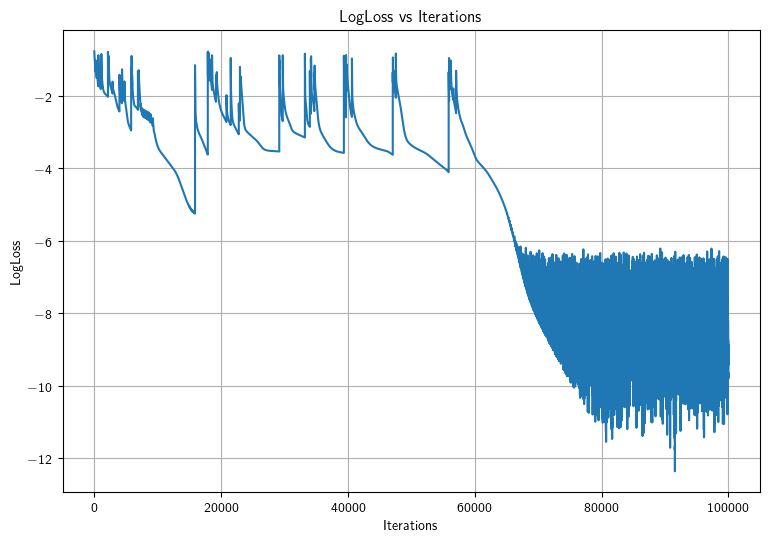

In [38]:
plt.figure(figsize=(9, 6))
plt.plot(np.arange(100000), np.log10(losses+losses2))
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.title('LogLoss vs Iterations')
plt.grid()

### Results

In [39]:
print('Best Loss =', best_loss2)

Best Loss = 4.3002798e-13


In [40]:
print('Target Matrix A: \n', target_matrix, '\n')
print('Estimated Matrix: \n', best_layer2.matrix)

Target Matrix A: 
 [[ 5.5872396e-02-0.00391302j -3.8370144e-02-0.00128841j
  -5.3430989e-02+0.29968864j -2.2154969e-01-0.0019728j
   1.3418485e-01+0.08630025j  2.9097015e-01-0.0852694j ]
 [ 3.5108021e-01-0.04888691j -2.4533357e-02-0.2933885j
   2.3281771e-01+0.12869121j  8.1600532e-02-0.0161135j
   2.6103365e-01-0.09597984j  9.7798914e-01-0.35523364j]
 [-3.7930824e-02+0.20811878j  4.6090059e-02-0.15567115j
  -1.6318266e-01-0.44207093j  6.6604517e-02+0.13224806j
   1.0893299e-01-0.07772399j  2.5994418e-02+0.30644378j]
 [-3.1416278e-02+0.03879942j  6.4945132e-02+0.20582628j
   1.6449971e-01-0.21622352j -3.7824544e-01-0.7196536j
   3.6285579e-02-0.13712242j  2.8667590e-01+0.02737086j]
 [ 4.2561609e-01+0.2037015j   5.0923411e-02-0.01099025j
   2.4804564e-01+0.32732105j -4.6988957e-02-0.11916979j
  -9.3551522e-01-0.4025315j   2.0018371e-02-0.04945949j]
 [-3.7660512e-01+0.19494618j -1.7610438e-02-0.02534192j
  -2.2346067e-01-0.08835632j  8.4407628e-04+0.02220193j
  -5.0199276e-01-0.09306701j

U block

In [45]:
print('Actual theta errors: \n', A.u.theta.numpy(), '\n')
print('Estimated theta errors: \n', abs(best_layer2.u.theta.numpy()), '\n')
print('Max theta error: \n', np.max(abs(A.u.theta.numpy() - best_layer2.u.theta.numpy())))
print('Mean theta error: \n', np.mean(abs(A.u.theta.numpy() - best_layer2.u.theta.numpy())))
print('Diff theta error: \n', abs(A.u.theta.numpy() - best_layer2.u.theta.numpy()))

Actual theta errors: 
 [[0.73501813 0.35633677 0.09968626]
 [0.35718012 0.4051426  0.        ]
 [0.22065629 0.2568008  0.57129824]
 [1.2549795  0.06754369 0.        ]
 [0.04757114 0.2683362  1.3461275 ]
 [0.17348738 0.24156496 0.        ]] 

Estimated theta errors: 
 [[2.5352466  0.7506455  1.44641   ]
 [0.33954942 2.176053   0.        ]
 [2.8121896  0.4053819  2.1022232 ]
 [0.39330357 1.8075519  0.        ]
 [1.6965476  0.29216278 0.3634361 ]
 [2.3242793  0.22544914 0.        ]] 

Max theta error: 
 2.5915332
Mean theta error: 
 0.9458293
Diff theta error: 
 [[1.8002285  0.39430875 1.3467237 ]
 [0.0176307  1.7709105  0.        ]
 [2.5915332  0.14858109 1.5309249 ]
 [0.8616759  1.7400081  0.        ]
 [1.6489764  0.02382657 0.9826914 ]
 [2.150792   0.01611581 0.        ]]


In [46]:
print('Actual phi errors: \n', A.u.phi.numpy(), '\n')
print('Estimated phi errors: \n', best_layer2.u.phi.numpy(), '\n')
print('Max phi error: \n', np.max(abs(A.u.phi.numpy() - best_layer2.u.phi.numpy()) % (2*np.pi)))
print('Mean phi error: \n', np.mean(abs(A.u.phi.numpy() - best_layer2.u.phi.numpy()) % (2*np.pi)))
print('Diff phi error: \n', abs(A.u.phi.numpy() - best_layer2.u.phi.numpy()) % (2*np.pi))

Actual phi errors: 
 [[1.2732826  0.00477878 0.9212361 ]
 [0.06217975 0.19591236 0.        ]
 [0.06226074 0.26155806 0.03823414]
 [0.41161242 0.5228699  0.        ]
 [0.21197847 0.48026833 1.078642  ]
 [0.2176273  0.88627315 0.        ]] 

Estimated phi errors: 
 [[3.7672346  1.6034254  3.1855257 ]
 [2.6308746  2.8127842  0.        ]
 [0.8701663  4.18626    5.9883785 ]
 [4.854697   0.78332853 0.        ]
 [3.14372    1.885613   3.045397  ]
 [3.0568023  6.02193    0.        ]] 

Max phi error: 
 5.9501443
Mean phi error: 
 2.2893014
Mean phi error: 
 [[2.4939518  1.5986466  2.2642896 ]
 [2.5686948  2.6168718  0.        ]
 [0.80790555 3.9247022  5.9501443 ]
 [4.4430847  0.26045865 0.        ]
 [2.9317415  1.4053446  1.966755  ]
 [2.839175   5.1356573  0.        ]]


In [47]:
print('Actual gamma errors: \n', A.u.gamma.numpy(), '\n')
print('Estimated gamma errors: \n', best_layer2.u.gamma.numpy(), '\n')
print('Max gamma error: \n', np.max(abs(A.u.gamma.numpy() - best_layer2.u.gamma.numpy()) % (2*np.pi)))
print('Mean gamma error: \n', np.mean(abs(A.u.gamma.numpy() - best_layer2.u.gamma.numpy()) % (2*np.pi)))
print('Diff gamma error: \n', abs(A.u.gamma.numpy() - best_layer2.u.gamma.numpy()) % (2*np.pi))

Actual gamma errors: 
 [[0.15558903 0.37870204 0.02470902 1.604749   0.671355   0.16753826]] 

Estimated gamma errors: 
 [[6.2211614 2.8660078 5.0394025 0.930817  2.551627  6.202363 ]] 

Max gamma error: 
 6.0655723
Mean gamma error: 
 3.6927664
Diff gamma error: 
 [[6.0655723  2.4873056  5.0146933  0.67393196 1.8802719  6.034825  ]]


Vt block

In [48]:
print('Actual theta errors: \n', A.v.theta.numpy(), '\n')
print('Estimated theta errors: \n', abs(best_layer2.u.theta.numpy()), '\n')
print('Max theta error: \n', np.max(abs(A.v.theta.numpy() - best_layer2.u.theta.numpy())))
print('Mean theta error: \n', np.mean(abs(A.v.theta.numpy() - best_layer2.u.theta.numpy())))
print('Diff theta error: \n', abs(A.v.theta.numpy() - best_layer2.u.theta.numpy()))

Actual theta errors: 
 [[0.18287602 0.7402936  0.19973363]
 [0.37225723 0.47912976 0.        ]
 [0.6919086  0.7037562  0.7926807 ]
 [0.8130649  0.24660344 0.        ]
 [0.0221603  0.16519693 0.25842187]
 [0.49947494 0.45245162 0.        ]] 

Estimated theta errors: 
 [[2.5352466  0.7506455  1.44641   ]
 [0.33954942 2.176053   0.        ]
 [2.8121896  0.4053819  2.1022232 ]
 [0.39330357 1.8075519  0.        ]
 [1.6965476  0.29216278 0.3634361 ]
 [2.3242793  0.22544914 0.        ]] 

Max theta error: 
 2.3523705
Mean theta error: 
 0.8336728
Diff theta error: 
 [[2.3523705  0.0103519  1.2466763 ]
 [0.03270781 1.6969233  0.        ]
 [2.120281   0.29837433 1.3095424 ]
 [0.4197613  1.5609484  0.        ]
 [1.6743873  0.12696585 0.10501423]
 [1.8248043  0.22700247 0.        ]]


In [49]:
print('Actual phi errors: \n', A.v.phi.numpy(), '\n')
print('Estimated phi errors: \n', best_layer2.u.phi.numpy(), '\n')
print('Max phi error: \n', np.max(abs(A.v.phi.numpy() - best_layer2.u.phi.numpy()) % (2*np.pi)))
print('Mean phi error: \n', np.mean(abs(A.v.phi.numpy() - best_layer2.u.phi.numpy()) % (2*np.pi)))
print('Diff phi error: \n', abs(A.v.phi.numpy() - best_layer2.u.phi.numpy()) % (2*np.pi))

Actual phi errors: 
 [[0.84733224 1.3828136  0.192477  ]
 [0.41307282 0.46561748 0.        ]
 [0.714853   0.09844973 0.33693627]
 [0.04714926 0.41485545 0.        ]
 [0.02632521 0.8738582  0.65963876]
 [0.2731028  0.7128986  0.        ]] 

Estimated phi errors: 
 [[3.7672346  1.6034254  3.1855257 ]
 [2.6308746  2.8127842  0.        ]
 [0.8701663  4.18626    5.9883785 ]
 [4.854697   0.78332853 0.        ]
 [3.14372    1.885613   3.045397  ]
 [3.0568023  6.02193    0.        ]] 

Max phi error: 
 5.651442
Mean phi error: 
 2.2431533
Diff phi error: 
 [[2.9199023  0.22061181 2.9930487 ]
 [2.2178018  2.3471668  0.        ]
 [0.15531331 4.0878105  5.651442  ]
 [4.807548   0.36847308 0.        ]
 [3.1173947  1.0117548  2.3857584 ]
 [2.7836995  5.3090315  0.        ]]


In [50]:
print('Actual gamma errors: \n', A.v.gamma.numpy(), '\n')
print('Estimated gamma errors: \n', best_layer2.u.gamma.numpy(), '\n')
print('Max gamma error: \n', np.max(abs(A.v.gamma.numpy() - best_layer2.u.gamma.numpy()) % (2*np.pi)))
print('Mean gamma error: \n', np.mean(abs(A.v.gamma.numpy() - best_layer2.u.gamma.numpy()) % (2*np.pi)))
print('Diff gamma error: \n', abs(A.v.gamma.numpy() - best_layer2.u.gamma.numpy()) % (2*np.pi))

Actual gamma errors: 
 [[0.5453457  0.7345789  1.0649463  0.2781937  0.9718706  0.34106997]] 

Estimated gamma errors: 
 [[6.2211614 2.8660078 5.0394025 0.930817  2.551627  6.202363 ]] 

Max gamma error: 
 5.861293
Mean gamma error: 
 3.3125622
Diff gamma error: 
 [[5.6758156 2.131429  3.9744563 0.6526233 1.5797563 5.861293 ]]


With bounding of parameters:

In [127]:
def constraint_fn(upper_bound):
    return lambda x: x - (upper_bound * tf.floor(x / upper_bound))

In [137]:
target_matrix = A.matrix
# Instantiate an optimizer
optimizer = Adam(learning_rate=0.0025)
# Instantiate a loss function
loss_fn = frobenius_loss
# Instantiate the ideal mesh
layer3 = SVD(6, mesh_dict={"name" : "rm", "properties" : {"constraint_fns" : [constraint_fn(0.3 * np.pi), constraint_fn(0.3 * 2 * np.pi), constraint_fn(0.3 * 2 * np.pi)]}})
_ = NormalPhaseInitializer(layer3.u, 0.1)      
_ = NormalPhaseInitializer(layer3.v, 0.1)       
# g = np.zeros((1, 6))
# g_ = tf.convert_to_tensor(g, dtype=tf.float32)
# layer.u.gamma.assign(g_)
# Preparing the training data
x_train, y_train = tf.eye(layer.units, dtype=TF_COMPLEX),\
                               tf.convert_to_tensor(target_matrix, dtype=TF_COMPLEX)

In [138]:
best_layer3, best_loss3, losses3 = train_layer(layer3, x_train, y_train, loss_fn, optimizer, 100000)

1000 iterations completed. Best Loss = 1.5399694442749023
2000 iterations completed. Best Loss = 1.3324902057647705
3000 iterations completed. Best Loss = 0.8896596431732178
4000 iterations completed. Best Loss = 0.697310745716095
5000 iterations completed. Best Loss = 0.697310745716095
6000 iterations completed. Best Loss = 0.697310745716095
7000 iterations completed. Best Loss = 0.45956742763519287
8000 iterations completed. Best Loss = 0.42951831221580505
9000 iterations completed. Best Loss = 0.42951831221580505
10000 iterations completed. Best Loss = 0.42951831221580505
11000 iterations completed. Best Loss = 0.42951831221580505
12000 iterations completed. Best Loss = 0.42951831221580505
13000 iterations completed. Best Loss = 0.42951831221580505
14000 iterations completed. Best Loss = 0.4116106927394867
15000 iterations completed. Best Loss = 0.4116106927394867
16000 iterations completed. Best Loss = 0.4116106927394867
17000 iterations completed. Best Loss = 0.4116106927394867
18

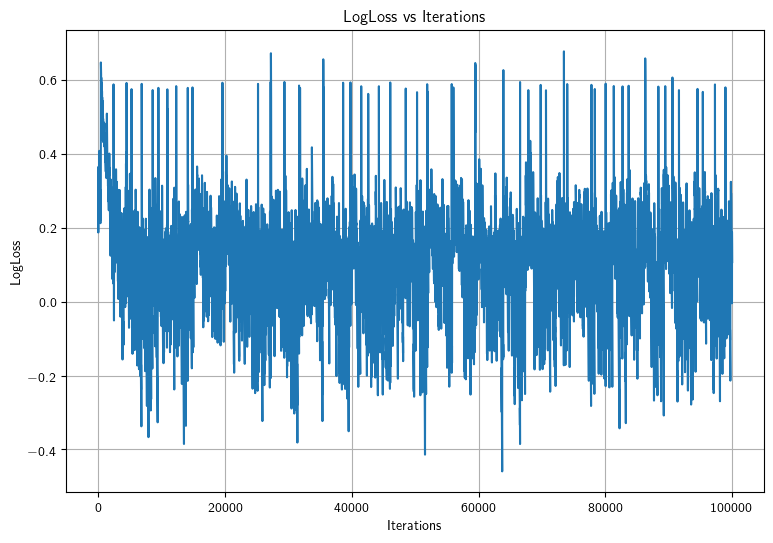

In [141]:
plt.figure(figsize=(9, 6))
plt.plot(np.arange(100000), np.log10(losses3))
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.title('LogLoss vs Iterations')
plt.grid()

### Results

In [ ]:
print('Best Loss =', best_loss)

Best Loss = 0.5468307


In [ ]:
print('Target Matrix A: \n', target_matrix, '\n')
print('Estimated Matrix: \n', best_layer.matrix)

Target Matrix A: 
 [[-3.3837698e-02-5.6935311e-03j  3.7037395e-04+2.6580701e-03j
   8.0650218e-02+3.8608249e-02j -1.0843638e-01-3.8679089e-02j
   4.8328638e-02-7.3957980e-02j  3.9026469e-02-7.8905839e-03j]
 [ 2.1720750e-02-4.2191911e-03j -2.4434465e-01+2.7366212e-02j
   9.1235086e-02-9.9194804e-03j  5.6606539e-02+9.2248712e-04j
  -1.3326780e-01+3.1415932e-02j  2.6521185e-01-9.6863285e-02j]
 [ 1.9019021e-02+1.7262030e-02j -5.2637089e-02-5.9970032e-02j
  -2.0841801e-01-1.0516982e-01j  4.6534208e-04+4.6220263e-03j
  -2.7963004e-04+3.6082674e-02j -4.1636988e-04+7.1906567e-02j]
 [ 1.3505919e-02+8.8327546e-03j  9.2776336e-02-6.6263236e-02j
  -1.6616723e-02+2.3760863e-02j -3.4977940e-01-5.8407873e-01j
  -2.5579870e-02+6.2840067e-02j  1.0231459e-01-1.1740315e-03j]
 [-2.3171686e-02+5.0394241e-02j -4.9262907e-02-2.8826252e-02j
  -6.1692361e-02+7.1941540e-02j -3.3995610e-02-2.1909565e-02j
  -6.4887613e-01-6.1998302e-01j -1.7314209e-01+4.7298765e-01j]
 [-6.8231627e-02-6.4676479e-02j -1.3338886e-02

U block

In [ ]:
print('Actual theta errors: \n', A.u.theta.numpy(), '\n')
print('Estimated theta errors: \n', abs(best_layer.u.theta.numpy()), '\n')
print('Max theta error: \n', np.max(abs(A.u.theta.numpy() - best_layer.u.theta.numpy())))

Actual theta errors: 
 [[0.22071603 0.03166671 1.0403107 ]
 [0.36397892 0.18251099 0.        ]
 [0.25317445 0.01099489 0.06422294]
 [0.5389042  0.2023556  0.        ]
 [0.2515069  0.34030336 0.76168144]
 [0.14432089 0.25964257 0.        ]] 

Estimated theta errors: 
 [[1.4279921e-01 1.8977325e-01 3.8745061e-01]
 [1.9934703e-01 1.7180730e-01 0.0000000e+00]
 [2.1042608e-01 6.8268646e-04 4.5704115e-02]
 [4.8295237e-02 1.3818213e-01 0.0000000e+00]
 [1.2981132e-01 2.8469229e-01 7.5289410e-01]
 [1.5515372e-01 3.7108529e-01 0.0000000e+00]] 

Max theta error: 
 0.65286016


In [ ]:
print('Actual phi errors: \n', A.u.phi.numpy(), '\n')
print('Estimated phi errors: \n', best_layer.u.phi.numpy(), '\n')
print('Max phi error: \n', np.max(abs(A.u.phi.numpy() - best_layer.u.phi.numpy()) % (2*np.pi)))

Actual phi errors: 
 [[0.6624301  0.06891035 1.0966022 ]
 [0.8326     0.7378072  0.        ]
 [0.93504155 0.13677499 0.38200453]
 [1.2363635  0.46307656 0.        ]
 [0.17328872 0.41467866 1.2379863 ]
 [0.33430248 1.2384747  0.        ]] 

Estimated phi errors: 
 [[1.0894687  3.3616478  6.0598016 ]
 [1.539901   0.10639426 0.        ]
 [2.7081156  4.0564404  2.1585538 ]
 [5.9272833  5.6778803  0.        ]
 [3.987897   3.7019355  3.8551524 ]
 [5.4283094  5.874688   0.        ]] 

Max phi error: 
 5.2148037


In [ ]:
print('Actual gamma errors: \n', A.u.gamma.numpy(), '\n')
print('Estimated gamma errors: \n', best_layer.u.gamma.numpy(), '\n')
print('Max gamma error: \n', np.max(abs(A.u.gamma.numpy() - best_layer.u.gamma.numpy()) % (2*np.pi)))

Actual gamma errors: 
 [[1.1142758  0.62527543 0.229372   0.87350196 0.04678386 0.20347348]] 

Estimated gamma errors: 
 [[2.7375307 3.758267  1.6363162 5.5943017 5.6430697 2.6948478]] 

Max gamma error: 
 5.596286


Vt block

In [ ]:
print('Actual theta errors: \n', A.v.theta.numpy(), '\n')
print('Estimated theta errors: \n', abs(best_layer.v.theta.numpy()), '\n')
print('Max theta error: \n', np.max(abs(A.v.theta.numpy() - best_layer.v.theta.numpy())))

Actual theta errors: 
 [[0.09630461 0.8681137  0.05923879]
 [0.1578461  0.0239465  0.        ]
 [0.25942206 0.06372735 0.22783737]
 [0.20097776 0.2147553  0.        ]
 [0.27302063 0.08819859 0.3585978 ]
 [0.5344436  0.8334513  0.        ]] 

Estimated theta errors: 
 [[2.7574787  2.6939144  3.1415863 ]
 [1.3675102  1.2929894  0.        ]
 [0.6444893  2.6422853  0.9432256 ]
 [1.0735924  0.42559755 0.        ]
 [1.5575078  2.3759062  0.92112523]
 [1.4640555  1.9899031  0.        ]] 

Max theta error: 
 3.0823476


In [ ]:
print('Actual phi errors: \n', A.v.phi.numpy(), '\n')
print('Estimated phi errors: \n', best_layer.v.phi.numpy(), '\n')
print('Max phi error: \n', np.max(abs(A.v.phi.numpy() - best_layer.v.phi.numpy()) % (2*np.pi)))

Actual phi errors: 
 [[0.5729704  0.3023585  0.43762916]
 [0.17614913 0.08455956 0.        ]
 [0.38816732 0.01847249 0.2385399 ]
 [0.26745588 0.47418022 0.        ]
 [0.44684225 0.4840605  0.54248816]
 [0.30845526 0.19608153 0.        ]] 

Estimated phi errors: 
 [[6.0986066  3.4561205  1.4951911 ]
 [3.055338   0.00957471 0.        ]
 [3.088797   3.0359626  3.012057  ]
 [3.2719665  0.06019033 0.        ]
 [3.726362   0.14266516 0.03726061]
 [6.2309785  1.6781325  0.        ]] 

Max phi error: 
 5.922523


In [ ]:
print('Actual gamma errors: \n', A.v.gamma.numpy(), '\n')
print('Estimated gamma errors: \n', best_layer.v.gamma.numpy(), '\n')
print('Max gamma error: \n', np.max(abs(A.v.gamma.numpy() - best_layer.v.gamma.numpy()) % (2*np.pi)))

Actual gamma errors: 
 [[0.7205846  0.48854843 0.17097707 0.993588   0.8374938  0.72112906]] 

Estimated gamma errors: 
 [[1.0936468  3.8887475  3.3817096  0.80683154 3.4365284  0.12297237]] 

Max gamma error: 
 3.400199


## Clements Decomposition:

### Unitary Matrix

Assume the each phase shifters has some (fixed) error of the form
$$ \theta_i = \theta_{e, i} + \pi \frac{V_i^2}{V_{\pi}^2} $$
where $\theta_{e, i}$ is from a normal distribution $N(0, \sigma^2)$.

- If no voltage is applied, the phase shift of each PS would be equal to the phase error
- Measure the output ($\hat A$) produced by the chip for any identity input ($X = I$)
- Utilise `clement_decomposition_working` to find the phases that construct $\hat A$

In [51]:
layer = RM(6)
sigma = 0.1     # in rads, taken from literature 
theta_e, phi_e, gamma_e = NormalPhaseInitializer(layer, sigma)    # Sets the phases of the mesh
A_hat = layer.matrix

In [52]:
est_theta_e, est_phi_e, est_gamma_e = clements_decomposition_working(A_hat)

In [53]:
print('Actual theta errors: \n', theta_e, '\n')
print('Estimated theta errors: \n', est_theta_e, '\n')
print('Max theta error: \n', np.max(abs(theta_e - est_theta_e)))

Actual theta errors: 
 [[1.01756711 1.28184939 0.1427875 ]
 [0.27282018 0.41842753 0.        ]
 [0.51101299 0.10925122 0.42274633]
 [0.67238958 0.9620828  0.        ]
 [0.13696622 1.13796293 0.69549585]
 [0.91055378 0.34953419 0.        ]] 

Estimated theta errors: 
 [[1.01756728 1.28184931 0.14278748]
 [0.27282023 0.41842752 0.        ]
 [0.51101298 0.10925124 0.42274633]
 [0.67238948 0.96208279 0.        ]
 [0.1369662  1.13796284 0.69549579]
 [0.91055376 0.34953416 0.        ]] 

Max theta error: 
 1.7143244579465033e-07


In [54]:
print('Actual phi errors: \n', phi_e, '\n')
print('Estimated phi errors: \n', est_phi_e, '\n')
print('Max phi error: \n', np.max(abs(phi_e - est_phi_e)))

Actual phi errors: 
 [[0.38399663 0.64527524 0.37818202]
 [0.31664053 0.21234023 0.        ]
 [0.23501327 0.11435591 0.05540658]
 [1.07348118 0.09694035 0.        ]
 [0.30284812 0.27360876 0.09571089]
 [1.05179206 0.43769914 0.        ]] 

Estimated phi errors: 
 [[0.38399645 0.64527498 0.37818182]
 [0.31664051 0.21234085 0.        ]
 [0.23501327 0.11435508 0.05540658]
 [1.07348136 0.09694026 0.        ]
 [0.30284794 0.27360869 0.09571073]
 [1.05179207 0.43769916 0.        ]] 

Max phi error: 
 8.320200100969677e-07


In [55]:
print('Actual gamma errors: \n', gamma_e, '\n')
print('Estimated gamma errors: \n', est_gamma_e, '\n')
print('Max gamma error: \n', np.max(abs(gamma_e - est_gamma_e)))

Actual gamma errors: 
 [[0.15171956 0.74239734 0.27767813 0.04872196 0.22392467 0.79830723]] 

Estimated gamma errors: 
 [0.15171965 0.74239757 0.27767828 0.04872224 0.22392484 0.79830774] 

Max gamma error: 
 5.081578459131819e-07


### SVD Mesh

In [56]:
A = SVD(6, mesh_dict={"name" : "rm"})
phasesU = NormalPhaseInitializer(A.u, 0.1)
phasesV = NormalPhaseInitializer(A.v, 0.1)
target_matrix = A.matrix

In [73]:
np.arccos(A.diag.matrix / A.diag.matrix[0][0])

array([[3.4526698e-04-0.j, 1.5707964e+00-0.j, 1.5707964e+00-0.j,
        1.5707964e+00-0.j, 1.5707964e+00-0.j, 1.5707964e+00-0.j],
       [1.5707964e+00-0.j, 7.0897037e-01-0.j, 1.5707964e+00-0.j,
        1.5707964e+00-0.j, 1.5707964e+00-0.j, 1.5707964e+00-0.j],
       [1.5707964e+00-0.j, 1.5707964e+00-0.j, 9.3405724e-01-0.j,
        1.5707964e+00-0.j, 1.5707964e+00-0.j, 1.5707964e+00-0.j],
       [1.5707964e+00-0.j, 1.5707964e+00-0.j, 1.5707964e+00-0.j,
        1.1730739e+00-0.j, 1.5707964e+00-0.j, 1.5707964e+00-0.j],
       [1.5707964e+00-0.j, 1.5707964e+00-0.j, 1.5707964e+00-0.j,
        1.5707964e+00-0.j, 1.3025788e+00-0.j, 1.5707964e+00-0.j],
       [1.5707964e+00-0.j, 1.5707964e+00-0.j, 1.5707964e+00-0.j,
        1.5707964e+00-0.j, 1.5707964e+00-0.j, 1.3860269e+00-0.j]],
      dtype=complex64)

In [81]:
sig1 = np.arccos(A.diag.sigma.numpy() / A.diag.sigma.numpy()[0])

In [57]:
U, S, Vt = np.linalg.svd(target_matrix)

In [82]:
sig2 = np.arccos(S / S[0])

In [83]:
abs(sig1 - sig2)

array([0.0000000e+00, 5.9604645e-08, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [58]:
tU, pU, gU = clements_decomposition_working(U)

In [59]:
print('Actual theta errors: \n', A.u.theta.numpy(), '\n')
print('Estimated theta errors: \n', tU, '\n')
print('Max theta error: \n', np.max(abs(A.u.theta.numpy() - tU)))

Actual theta errors: 
 [[0.6557315  0.37542844 0.04917571]
 [0.1640289  0.66387886 0.        ]
 [0.2303793  0.27978522 0.00074264]
 [0.4160385  0.4100974  0.        ]
 [0.18749979 0.16907874 0.5846267 ]
 [0.32602835 0.48860356 0.        ]] 

Estimated theta errors: 
 [[0.65573138 0.37542833 0.04917565]
 [0.1640289  0.66387887 0.        ]
 [0.23037929 0.27978524 0.00074266]
 [0.41603857 0.41009733 0.        ]
 [0.18749985 0.16907873 0.58462662]
 [0.32602861 0.48860356 0.        ]] 

Max theta error: 
 2.6273768821694077e-07


In [62]:
print('Actual phi errors: \n', A.u.phi.numpy(), '\n')
print('Estimated phi errors: \n', pU, '\n')
print('Max phi error: \n', np.max(abs(A.u.phi.numpy() - pU) % (2*np.pi)))
print('Mean phi error: \n', np.mean(abs(A.u.phi.numpy() - pU) % (2*np.pi)))
print('Diff phi error: \n', abs(A.u.phi.numpy() - pU) % (2*np.pi))

Actual phi errors: 
 [[0.18277872 0.8577447  0.6548631 ]
 [1.1292001  0.2930678  0.        ]
 [1.1063074  0.41615808 0.18515512]
 [0.30344936 0.42619687 0.        ]
 [0.7322223  0.42425907 0.2686882 ]
 [0.16412646 0.04651771 0.        ]] 

Estimated phi errors: 
 [[0.22312045 0.85774471 0.65483773]
 [1.16954193 0.29306805 0.        ]
 [0.75476842 0.45649964 0.18512916]
 [6.23509545 0.46653887 0.        ]
 [0.55809323 0.07272009 0.30903003]
 [6.0030118  0.14438324 0.        ]] 

Max phi error: 
 5.9316460909197275
Mean phi error: 
 0.7192980316846292
Diff phi error: 
 [[4.03417386e-02 2.00174348e-08 2.53877947e-05]
 [4.03418328e-02 2.32308780e-07 0.00000000e+00]
 [3.51538969e-01 4.03415648e-02 2.59653352e-05]
 [5.93164609e+00 4.03419966e-02 0.00000000e+00]
 [1.74129089e-01 3.51538977e-01 4.03418247e-02]
 [5.83888535e+00 9.78655341e-02 0.00000000e+00]]


In [63]:
print('Actual gamma errors: \n', A.u.gamma.numpy(), '\n')
print('Estimated gamma errors: \n', gU, '\n')
print('Max gamma error: \n', np.max(abs(A.u.gamma.numpy() - gU) % (2*np.pi)))
print('Mean gamma error: \n', np.mean(abs(A.u.gamma.numpy() - gU) % (2*np.pi)))
print('Diff gamma error: \n', abs(A.u.gamma.numpy() - gU) % (2*np.pi))

Actual gamma errors: 
 [[0.41954955 0.2162746  0.36828926 0.27407655 0.4069663  0.28418517]] 

Estimated gamma errors: 
 [1.72064858 1.51737376 1.66938839 1.5751756  1.70809128 1.58530968] 

Max gamma error: 
 1.3011249770015443
Mean gamma error: 
 1.3011076395047736
Diff gamma error: 
 [[1.30109902 1.30109916 1.30109912 1.30109905 1.30112498 1.3011245 ]]


Vt block

In [64]:
tV, pV, gV = clements_decomposition_working(Vt)

In [65]:
print('Actual theta errors: \n', A.v.theta.numpy(), '\n')
print('Estimated theta errors: \n', tV, '\n')
print('Max theta error: \n', np.max(abs(A.v.theta.numpy() - tV)))

Actual theta errors: 
 [[0.73509276 0.0520671  0.22608204]
 [0.33819503 0.5096436  0.        ]
 [0.66692543 0.4020302  0.0928681 ]
 [0.09028345 0.3941619  0.        ]
 [0.501651   0.5614606  0.35164514]
 [1.5359147  0.1471504  0.        ]] 

Estimated theta errors: 
 [[0.7350927  0.05206724 0.2260821 ]
 [0.33819502 0.50964363 0.        ]
 [0.6669255  0.4020303  0.09286821]
 [0.09028339 0.39416196 0.        ]
 [0.50165098 0.56146061 0.35164521]
 [1.5359146  0.14715061 0.        ]] 

Max theta error: 
 2.1536344776973415e-07


In [66]:
print('Actual phi errors: \n', A.v.phi.numpy(), '\n')
print('Estimated phi errors: \n', pV, '\n')
print('Max phi error: \n', np.max(abs(A.v.phi.numpy() - pV) % (2*np.pi)))

Actual phi errors: 
 [[0.6450926  0.3751948  0.47809076]
 [0.19232881 0.36791363 0.        ]
 [0.07412916 0.04911941 0.5533881 ]
 [0.12578383 0.67877734 0.        ]
 [0.20482713 0.2557948  0.7587257 ]
 [0.094331   0.684147   0.        ]] 

Estimated phi errors: 
 [[0.64509256 0.37519497 0.47809118]
 [0.19232866 0.36791309 0.        ]
 [0.07412916 0.0491184  0.553388  ]
 [0.1257847  0.67877741 0.        ]
 [0.20482718 0.25579456 0.75872593]
 [0.09433103 0.6841462  0.        ]] 

Max phi error: 
 1.014898658446839e-06


In [69]:
print('Actual gamma errors: \n', A.v.gamma.numpy(), '\n')
print('Estimated gamma errors: \n', gU, '\n')
print('Max gamma error: \n', np.max(abs(A.v.gamma.numpy() - gU) % (2*np.pi)))
print('Mean gamma error: \n', np.mean(abs(A.v.gamma.numpy() - gU) % (2*np.pi)))
print('Diff gamma error: \n', abs(A.v.gamma.numpy() - gU) % (2*np.pi))

Actual gamma errors: 
 [[0.41560593 0.91437507 0.24508443 0.6028981  0.11570595 0.07536417]] 

Estimated gamma errors: 
 [1.72064858 1.51737376 1.66938839 1.5751756  1.70809128 1.58530968] 

Max gamma error: 
 1.5923853237718308
Mean gamma error: 
 1.2344922678503425
Diff gamma error: 
 [[1.30504265 0.6029987  1.42430395 0.97227748 1.59238532 1.50994551]]


## Determining $\Sigma$ Block Phase Errors

$$E_{out} = E_{in} e^{j\phi} \cos(\Delta)  $$
where $\phi = \frac{\theta_1+\theta_2}{2}$ and $\Delta = \frac{\theta_1-\theta_2}{2}$

For $E_{out} = 0$, we need $\Delta = \pi/2$, which implies $\theta_1 - \theta_2 = \pi$.

In practice, $\theta_1' - \theta_2' = \pi$. From this, we can determine the phase errors.

$f(V_1) - f(V_2) + \theta_{1, e} - \theta_{2, e} = \pi$ 

$\implies \theta_{1, e} - \theta_{2, e} = \pi + f(V_2) - f(V_1)$


In [84]:
def MZM(theta1, theta2, bias):
    phi = (theta1 + theta2 + np.sum(bias)) / 2
    return np.exp(phi * 1j) * np.cos(theta1 - theta2 + bias[0] - bias[1])

In [85]:
def MZM_(phases, biases):
    phi = (np.sum(phases, axis=1) + np.sum(biases, axis=1)) / 2
    return np.exp(phi * 1j) * np.cos((phases[:, 0] - phases[:, 1] + biases[:, 0] - biases[:, 1]) / 2)

In [91]:
# Fixed quantities
U = sp.stats.unitary_group.rvs(6)
S = np.random.rand(6, 1)
Vt = sp.stats.unitary_group.rvs(6)
x = np.random.rand(6, 1)
biases = 0.02 * np.pi * np.random.rand(6, 2)

In [92]:
min_loss = np.inf
best_phases = np.zeros(12)
itr = 0
losses = []

def loss(phases):
    global itr, biases, min_loss, best_phases, U, Vt, x, losses
    phases_ = phases.reshape(6, 2)
    output = MZM_(phases_, biases)
    y = U @ np.diag(output.reshape(-1)) @ Vt @ x
    loss = np.linalg.norm(y)
    if loss < min_loss:
        min_loss = loss
        best_phases = phases
    print(f"Iter: {itr}, loss: {loss}")
    losses.append(loss)
    itr += 1
    return loss

In [93]:
res = minimize(
  loss,
  x0=best_phases,
  bounds= ((0, 2*np.pi) for _ in best_phases),
  method='Powell',
  options={'maxiter': 1000},
)

Iter: 0, loss: 1.2987842958547071
Iter: 1, loss: 1.2438320539771286
Iter: 2, loss: 1.2444347948222103
Iter: 3, loss: 1.2699361037210912
Iter: 4, loss: 1.235658851162879
Iter: 5, loss: 1.2356587125810752
Iter: 6, loss: 1.2356587049960717
Iter: 7, loss: 1.2356587049439451
Iter: 8, loss: 1.2356587049619792
Iter: 9, loss: 1.2906736213984946
Iter: 10, loss: 1.290673621388787
Iter: 11, loss: 1.2648543446869032
Iter: 12, loss: 1.2482694126226535
Iter: 13, loss: 1.2407061265246633
Iter: 14, loss: 1.2376213506003138
Iter: 15, loss: 1.2364134929594923
Iter: 16, loss: 1.2359477593502324
Iter: 17, loss: 1.2357692236702988
Iter: 18, loss: 1.2357009353665724
Iter: 19, loss: 1.2356748378686575
Iter: 20, loss: 1.2356648675140394
Iter: 21, loss: 1.235661058886018
Iter: 22, loss: 1.2356596040770522
Iter: 23, loss: 1.2356590483832783
Iter: 24, loss: 1.235658836126244
Iter: 25, loss: 1.235658755051142
Iter: 26, loss: 1.2356587240831913
Iter: 27, loss: 1.2356587122544853
Iter: 28, loss: 1.235658707736322
I

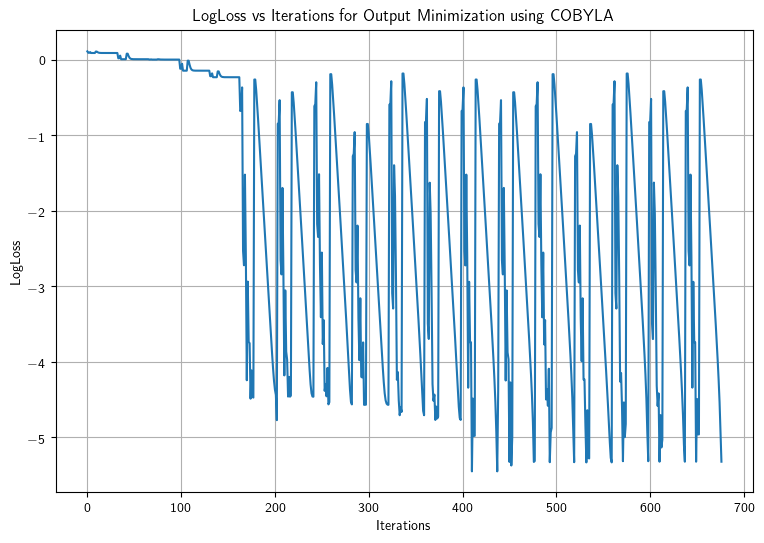

In [95]:
plt.figure(figsize=(9, 6))
plt.plot(np.arange(len(losses)), np.log10(losses))
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.title('LogLoss vs Iterations for Output Minimization using COBYLA')
plt.grid()

In [96]:
np.linalg.norm(MZM_(best_phases.reshape(6, 2), biases))

7.805532542949318e-06

In [99]:
applied_phase = best_phases.reshape(6, 2) + biases

In [101]:
abs(applied_phase[:, 0] - applied_phase[:, 1])

array([3.14160224, 3.1415958 , 3.1415855 , 3.14159911, 3.14159966,
       3.1415926 ])

## Particle Swarm Optimisation:

In [ ]:
def objective_function(phases):    
    # Convert phases into a 6x6 complex matrix B
    B = compute_complex_matrix(phases)
    
    # Target matrix A (predefined)
    A = np.array(...)  # Define your target matrix here
    
    # Calculate the Frobenius norm (or another suitable norm)
    loss = np.linalg.norm(A - B, 'fro')
    
    return loss

def compute_complex_matrix(phases):
    
    return 

## Optimization over V (incomplete)

$$ \theta_i = \theta_{e, i} + \pi \frac{V_i^2}{V_{\pi, i}^2} $$
When both $\theta_e$ and $V_{\pi}$ vary for each phase shifter, can we optimize the voltages to get a reasonable $\hat A$? 

- $\theta_e$ taken from $N(0,\ 0.1^2)$
- $V_{\pi}$ taken from $N(2.4,\ 0.1^2)$


In [96]:
def phase_shifter(V, theta_b, V_pi: float = 2.4):
    return theta_b + np.pi * (V / V_pi)**2

In [102]:
def PhaseInitializer(layer: RM, theta: np.ndarray, phi: np.ndarray, gamma: np.ndarray):
    """Initialises a mesh layer with the desired phases

    Args:
        layer (RM): Neurophox rectangular mesh layer
        theta (np.ndarray): Theta
        phi (np.ndarray): Phi
        gamma (np.ndarray): Gamma
    """
    t_ = tf.convert_to_tensor(theta, dtype=tf.float32)
    p_ = tf.convert_to_tensor(phi, dtype=tf.float32)
    g_ = tf.convert_to_tensor(gamma.reshape(1, -1), dtype=tf.float32)
    layer.theta.assign(t_)
    layer.phi.assign(p_)
    layer.gamma.assign(g_)
    # print('Phases have been initialized successfully.')

In [121]:
U = sp.stats.unitary_group.rvs(6)
layer = RM(U.shape[0])

In [122]:
# Initialise layer
V_theta = 2.4 * np.random.rand(layer.theta.shape[0], layer.theta.shape[1])
V_theta[1::2, -1] = 0
V_theta = tf.Variable(V_theta, trainable=True, name='V_t', dtype=np.float32)
V_phi = 3.4 * np.random.rand(layer.phi.shape[0], layer.phi.shape[1])
V_phi[1::2, -1] = 0
V_phi = tf.Variable(V_phi, trainable=True, name='V_p', dtype=np.float32)
V_gamma = tf.Variable(3.4 * np.random.rand(*layer.gamma.shape), trainable=True, name='V_g', dtype=np.float32)

# Set all the unknown constants
theta_b = abs(np.random.normal(0, 0.1, layer.theta.shape))
theta_b[1::2, -1] = 0
v_pi_t = np.random.normal(2.4, 0.1, layer.theta.shape)
# v_pi_t[1::2, -1] = 0
# theta_b = tf.constant(theta_b, dtype=np.float32)
phi_b = abs(np.random.normal(0, 0.1, layer.phi.shape))
phi_b[1::2, -1] = 0
v_pi_p = np.random.normal(2.4, 0.1, layer.phi.shape)
# v_pi_p[1::2, -1] = 0
# phi_b = tf.constant(phi_b, dtype=np.float32)
gamma_b = np.random.normal(0, 0.1, layer.gamma.shape)
v_pi_g = np.random.normal(2.4, 0.1, layer.gamma.shape)

In [123]:
V_0 = np.concatenate([V_theta.numpy().flatten(), V_phi.numpy().flatten(), V_gamma.numpy().flatten()])
V_t_shape = V_theta.numpy().shape
V_t_size = V_t_shape[0] * V_t_shape[1]
V_g_shape = V_gamma.numpy().shape

In [124]:
params = []
minv = 1000
itr = 0

def loss(V):
    global U, V_t_shape, V_t_size, V_g_shape, theta_b, phi_b, gamma_b, v_pi_t, v_pi_p, v_pi_g, params, itr, minv

    V_t = V[:V_t_size].reshape(V_t_shape)
    V_p = V[V_t_size:2*V_t_size].reshape(V_t_shape)
    V_g = V[2*V_t_size:].reshape(V_g_shape)

    t = phase_shifter(V_t, theta_b, v_pi_t)
    p = phase_shifter(V_p, phi_b, v_pi_p)
    g = phase_shifter(V_g, gamma_b, v_pi_g)

    layer = RM(U.shape[0])
    PhaseInitializer(layer, t, p, g)
    U_hat = layer.matrix
    
    diff = np.linalg.norm(U - U_hat)
    if diff < minv:
        params = V
        minv = diff
    # endif

    print(f"Iter: {itr}, Norm: {diff}")
    itr += 1
    return diff

In [125]:
res = minimize(
  loss,
  x0=V_0,
  bounds=((0,4) for _ in V_0),
  method='cobyla',
  options={'maxiter': 1000},
)

Iter: 0, Norm: 3.5043829242566416
Iter: 1, Norm: 3.4375135898077933
Iter: 2, Norm: 3.3061432790266196
Iter: 3, Norm: 3.285942144710271
Iter: 4, Norm: 3.320081923043846
Iter: 5, Norm: 3.284631868364329
Iter: 6, Norm: 3.284631868364329
Iter: 7, Norm: 3.422438661014098
Iter: 8, Norm: 3.3333444422232765
Iter: 9, Norm: 3.311408621824471
Iter: 10, Norm: 3.118130139022324
Iter: 11, Norm: 3.2534684132681324
Iter: 12, Norm: 3.118130139022324
Iter: 13, Norm: 3.161613520207217
Iter: 14, Norm: 3.250083754209383
Iter: 15, Norm: 3.0304820467953224
Iter: 16, Norm: 3.147888447748501
Iter: 17, Norm: 3.0184637567972326
Iter: 18, Norm: 3.0184637567972326
Iter: 19, Norm: 3.130336399499919
Iter: 20, Norm: 2.9682213045550254
Iter: 21, Norm: 3.3024310508973325
Iter: 22, Norm: 2.9974184497607026
Iter: 23, Norm: 3.1757488297548053
Iter: 24, Norm: 2.9682213045550254
Iter: 25, Norm: 2.990718772952625
Iter: 26, Norm: 3.1054378104735023
Iter: 27, Norm: 3.11347308420325
Iter: 28, Norm: 3.2183830537729854
Iter: 29, 

In [126]:
V_t = params[:V_t_size].reshape(V_t_shape)
V_p = params[V_t_size:2*V_t_size].reshape(V_t_shape)
V_g = params[2*V_t_size:].reshape(V_g_shape)

t = phase_shifter(V_t, theta_b, v_pi_t)
p = phase_shifter(V_p, phi_b, v_pi_p)
g = phase_shifter(V_g, gamma_b, v_pi_g)

layer = RM(U.shape[0])
PhaseInitializer(layer, t, p, g)
U_hat = layer.matrix

In [127]:
print('Target Matrix U: \n', U, '\n')
print('Estimated Matrix: \n', U_hat)

Target Matrix U: 
 [[ 0.15066288+0.18944218j  0.53592648+0.26206313j -0.09029956+0.41421043j
  -0.30377691+0.05606439j -0.06857385+0.32892136j  0.34908964-0.27498173j]
 [ 0.01305338+0.64566913j  0.06120987-0.10565473j  0.03657078+0.01495828j
   0.22496431+0.35426105j  0.1012297 -0.52081111j  0.32312183+0.06679098j]
 [-0.03515786+0.47578643j  0.18088795+0.13667934j  0.61180084-0.28591712j
  -0.11434809-0.28579137j -0.19271657+0.18752718j -0.27146035+0.15553649j]
 [-0.28962498-0.05534151j -0.1127428 -0.33792851j  0.21606269-0.11154723j
   0.31235927-0.07647489j -0.06709015+0.46102788j  0.63648661+0.03797992j]
 [-0.10804353-0.34182469j  0.22593714+0.54429704j  0.21700648-0.46651017j
   0.21069163+0.34082918j -0.00223806-0.13035814j  0.14128534-0.248871j  ]
 [ 0.22205749+0.17880767j -0.08189046+0.31124738j -0.11538986+0.15969164j
   0.5814421 +0.17795285j  0.29847732+0.45844937j -0.2431774 +0.21949749j]] 

Estimated Matrix: 
 [[ 0.2904813 +0.28264043j  0.10238722+0.39501077j  0.08275095+0.